# VAE(変分オートエンコーダー)

## VAEとは？
VAE(変分オートエンコーダ)の説明の前にオートエンコーダーとはなにか説明していきます  
  
### ・オートエンコーダー
オートエンコーダーとは、教師なし学習の一つでデータを表現する特徴を得るためのニューラルネットワークである。  
  
エンコーダで画像などのデータを潜在変数に落とし込み、デコーダから新たに生成します  
  
主な活用事例としてデータのノイズ除去やクラスタリング、そしてデータ生成など  
  
幅広く活用されています。

### ・変分オートエンコーダー
  
VAEはオートエンコーダーの拡張版で、データ生成に焦点を当てたモデルです。  
  
VAEは潜在変数を確率分布として扱います
  
そこでGMMを学んだわけですが、  
  
今回はGMMよりも表現力を向上させるため学習データに合わせて柔軟に形が決定できるものを目指していきます。

## VAEの実装

それではVAEの実装に入っていきます  
  
今回最大化するべ式は以下の通り

$$
\text{ELBO}(x; \theta, \phi) \approx -\frac{1}{2} \sum_{d=1}^{D} (x_d - \hat{x}_d)^2 + \frac{1}{2} \sum_{h=1}^{H} \left(1 + \log \sigma_h^2 - \mu_h^2 - \sigma_h^2 \right) + \text{const}

$$  
  
つまりLossは以下のようになる

$$
\text{Loss}(x; \theta, \phi) \approx \sum_{d=1}^{D} (x_d - \hat{x}_d)^2 - \sum_{h=1}^{H} \left(1 + \log \sigma_h^2 - \mu_h^2 - \sigma_h^2 \right)
$$

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


# hyperparameters
input_dim = 784  # x dimension
hidden_dim = 200  # neurons in hidden layers
latent_dim = 20  # z dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32

#VAEの実装
class Encoder(nn.Module): #2層NN
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x) # h = Wx + b
        h = F.relu(h) # h = ReLU(h)

        #平均uを出力
        mu = self.linear_mu(h)

        #各要素の分散が正の数になるように対数で出力
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)

        return mu, sigma


class Decoder(nn.Module): #2層NN
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h) #x_hatを出力
        return x_hat


def reparameterize(mu, sigma): #変数変換トリック
    eps = torch.randn_like(sigma) #標準正規分布からサンプリング
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size #ミニバッチ分の平均を返す


53.80080948079427
45.16803246866862
43.48621237182617
42.41853308105469
41.69882560831706
41.15069438680013
40.82676372680664
40.538628336588545
40.30939677734375
40.129791906738284
39.98806333007813
39.885891412353516
39.76769491373698
39.64906826171875
39.57845053914388
39.51520602722168
39.41233994140625
39.37541053466797
39.30661396687825
39.22617290039062
39.15902867838542
39.11647355143229
39.05023384806315
39.02034557495117
38.98380021972656
38.9222853129069
38.85057831217448
38.828660760498046
38.78015399983724
38.75332267456055


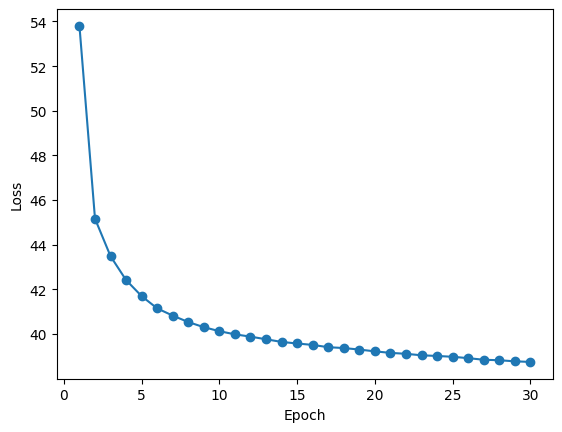

In [3]:
# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # falatten
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)

# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

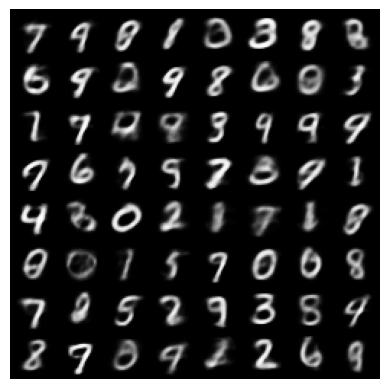

In [4]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()